✅ Libraries imported successfully.

📂 Loading datasets...
US dataset processed. Shape: (44898, 2)

Loading the third dataset ('news_dataset.csv')...
⚠️ news_dataset.csv not found. Continuing with only Fake.csv and True.csv.

✅ Combining all datasets...
✅ All datasets combined successfully!
Total samples: 44898
Class distribution:
 label
1    23481
0    21417
Name: count, dtype: int64

🧹 Cleaning text data...
✅ Text cleaning complete.

✂️ Splitting dataset...

🔤 Applying TF-IDF...

🤖 Training Logistic Regression...
✅ Model training complete.

📊 Evaluating the final model...
✅ Final Model Accuracy: 98.71%

Final Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.98      0.99      0.99      4284
    Fake (1)       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



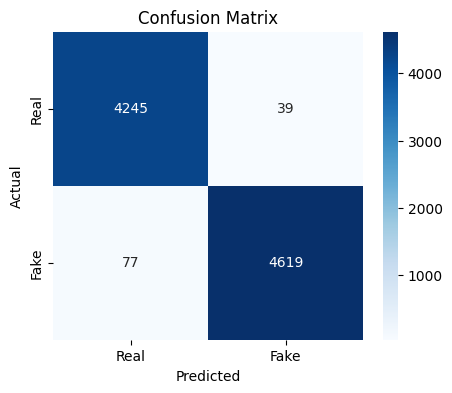

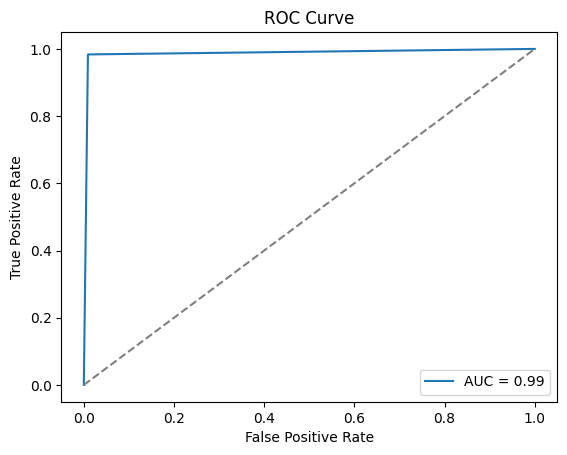


💾 Saving the final model and vectorizer...
✅ Files saved successfully as 'final_model.pkl' and 'final_vectorizer.pkl'


In [10]:
# ==============================================================================
# Step 1: Import All Necessary Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK stopwords (only needs to be done once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

print("✅ Libraries imported successfully.")

# ==============================================================================
# Step 2: Load, Standardize, and Combine Your Datasets
# ==============================================================================
print("\n📂 Loading datasets...")
df_fake_us = pd.read_csv('/content/fake.csv')
df_true_us = pd.read_csv('/content/true.csv')

df_fake_us['label'] = 1  # Fake = 1
df_true_us['label'] = 0  # Real = 0

df_us = pd.concat([df_true_us, df_fake_us], ignore_index=True)
df_us['full_text'] = df_us['title'] + ' ' + df_us['text']
df_us_standardized = df_us[['full_text', 'label']]
print(f"US dataset processed. Shape: {df_us_standardized.shape}")

# --- Load and Process the THIRD Dataset (news_dataset.csv) ---
print("\nLoading the third dataset ('news_dataset.csv')...")
try:
    df_new = pd.read_csv('news_dataset.csv')
    df_new.rename(columns={'text': 'full_text'}, inplace=True)
    df_new['label'] = df_new['label'].apply(lambda x: 0 if x == 'REAL' else 1)
    df_new_standardized = df_new[['full_text', 'label']]
    print(f"Third dataset processed. Shape: {df_new_standardized.shape}")
except FileNotFoundError:
    print("⚠️ news_dataset.csv not found. Continuing with only Fake.csv and True.csv.")
    df_new_standardized = pd.DataFrame(columns=['full_text', 'label'])

# --- Combine All Datasets ---
print("\n✅ Combining all datasets...")
df_combined = pd.concat([df_us_standardized, df_new_standardized], ignore_index=True)
df_combined.dropna(inplace=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
print(f"✅ All datasets combined successfully!\nTotal samples: {len(df_combined)}")
print("Class distribution:\n", df_combined['label'].value_counts())

# ==============================================================================
# Step 3: Preprocess and Clean the Text Data
# ==============================================================================
print("\n🧹 Cleaning text data...")
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    return text

df_combined['clean_text'] = df_combined['full_text'].apply(clean_text)
print("✅ Text cleaning complete.")

# ==============================================================================
# Step 4: Split Data, Vectorize, and Train the Model
# ==============================================================================
print("\n✂️ Splitting dataset...")
X = df_combined['clean_text']
y = df_combined['label'].astype(int)   # ✅ FIXED: ensure labels are integers

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n🔤 Applying TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

print("\n🤖 Training Logistic Regression...")
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(tfidf_train, y_train)
print("✅ Model training complete.")

# ==============================================================================
# Step 5: Evaluate the Final Model
# ==============================================================================
print("\n📊 Evaluating the final model...")
y_pred = model.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'✅ Final Model Accuracy: {accuracy * 100:.2f}%')
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ==============================================================================
# Step 6: Save the Model and Vectorizer
# ==============================================================================
print("\n💾 Saving the final model and vectorizer...")
joblib.dump(model, 'final_model.pkl')
joblib.dump(tfidf_vectorizer, 'final_vectorizer.pkl')
print("✅ Files saved successfully as 'final_model.pkl' and 'final_vectorizer.pkl'")
